In [ ]:
## import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d, gaussian_kde
from numba import njit
from astropy.io import fits

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

from scipy.ndimage import gaussian_filter

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [3]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [4]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388

GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [5]:
# sim0 = ('142', '116', '04')
# sim1 = ('129', '116', '04')

sim0 = ('129', '142', '04') # aa
sim1 = ('129', '116', '04') # a

In [6]:
def load_galaxy(sim, idx=320):
    if sim=='iso':
        return galaxy.Galaxy(basepath + 'runs/MW7iso/lvl4-Ngb64/output', idx, orient=True)
    
    Rs, Vv, ecc = sim
    key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
    return galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)

In [7]:
galiso = load_galaxy('iso')
gal0 = load_galaxy(sim0)
gal1 = load_galaxy(sim1)

In [8]:
def extract_sim_data(gal):
    sn = gal.sn
    
    ### get logFeH and logMgFe ###
    FeH = sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH

    ### get in_SN ###
    Lzsun = 8 * 220 * 0.2
    zmax = 3
    dLz = 0.3
    
    Lz = np.cross(sn.part4.rotpos, sn.part4.rotvel)[:,2]
    in_SN = np.logical_and(np.abs((Lz/Lzsun)-1) < dLz, np.abs(sn.part4.rotpos[:,2]) < zmax)
    
    ### get tform ###
    tform = sn.part4.GFM_StellarFormationTime
    keybool = np.logical_and(in_SN, tform > 0)
    
    out = {}
    out['logFeH'] = logFeH[in_SN]
    out['logMgFe'] = logMgFe[in_SN]
    out['tform'] = tform[in_SN]
    
    return out

simdata_iso = extract_sim_data(galiso)
simdata0 = extract_sim_data(gal0)
simdata1 = extract_sim_data(gal1)

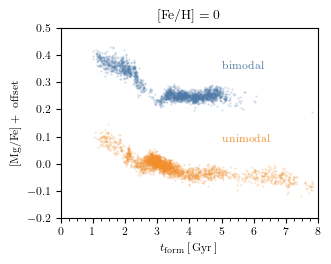

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.8*columnwidth))

logFeH0 = 0
dlogFeH = 0.05
s=0.4

data = simdata0
offset = 0
key = np.logical_and(data['logFeH'] > logFeH0 - dlogFeH/2, data['logFeH'] < logFeH0 + dlogFeH/2)
ax.scatter(data['tform'][key], data['logMgFe'][key]+offset, c=tb_c[0], s=s, alpha=0.2, label='bimodal')

data = simdata1
offset = -0.3
key = np.logical_and(data['logFeH'] > logFeH0 - dlogFeH/2, data['logFeH'] < logFeH0 + dlogFeH/2)
ax.scatter(data['tform'][key], data['logMgFe'][key]+offset, c=tb_c[1], s=s, alpha=0.2, label='unimodal')

# ax.set(xlim=(0, 8), ylim=(-0.1, 0.5), title=r'$-0.3 < [\textrm{Fe}/\textrm{H}] < -0.2$')
ax.set(xlim=(0, 8), ylim=(-0.2, 0.5), title=r'$[\textrm{Fe}/\textrm{H}] = 0$')
ax.set(xlabel=r'$t_{\textrm{form}}\,[\,\textrm{Gyr}\,]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
ax.text(5, 0.35, r'$\textrm{bimodal}$', c=tb_c[0])
ax.text(5, 0.08, r'$\textrm{unimodal}$', c=tb_c[1])
ax.set(xticks=np.arange(0, 8+1, 1))
ax.set_xticks(np.arange(0, 8+0.25, 0.25), minor=True)

# ax.legend(frameon=False)
fig.tight_layout()
fig.savefig('alpha_vs_tform.pdf')

In [10]:
# Now get APOKASC2 ages
from astropy.coordinates import SkyCoord, Galactic, Galactocentric
from astropy import units as u
from astropy.io import fits, ascii

fname = '../../data/APOKASC3/Table4.data'
data = ascii.read(fname)

In [11]:
def get_age_age_err(data):
    age_RC      = data['Age_RC_AGB'][data['Age_Cat'] == 'RC']
    age_RCp     = data['S_Age_RC+'][data['Age_Cat'] == 'RC']
    age_RCm     = data['S_Age'][data['Age_Cat'] == 'RC']
    age_RC_err  = np.maximum(age_RCp, -age_RCm)

    age_AGB     = data['Age_RC_AGB'][data['Age_Cat'] == 'AGB']
    age_AGBp    = data['S_Age_RC+'][data['Age_Cat'] == 'AGB']
    age_AGBm    = data['S_Age'][data['Age_Cat'] == 'AGB']
    age_AGB_err = np.maximum(age_AGBp, -age_AGBm)

    age_RGB     = data['Age_RGB'][data['Age_Cat'] == 'RGB']
    age_RGBp    = data['S_Age_RGB+'][data['Age_Cat'] == 'RGB']
    age_RGBm    = data['S_Age_RGB-'][data['Age_Cat'] == 'RGB']
    age_RGB_err = np.maximum(age_RGBp, -age_RGBm)

    age = np.full_like(data['Age_RGB'], np.nan)
    age[data['Age_Cat'] == 'RC']  = age_RC
    age[data['Age_Cat'] == 'AGB'] = age_AGB
    age[data['Age_Cat'] == 'RGB'] = age_RGB

    age_err = np.full_like(data['Age_RGB'], np.nan)
    age_err[data['Age_Cat'] == 'RC']  = age_RC_err
    age_err[data['Age_Cat'] == 'AGB'] = age_AGB_err
    age_err[data['Age_Cat'] == 'RGB'] = age_RGB_err
    
    return age, age_err

In [12]:
def get_MW_plot_data(N_FeH=128, N_MgFe=128, logFeH_lim=(-1.5, 0.5), logMgFe_lim=(-0.2, 0.8),
                     logFeH0_list = [-0.5, -0.25, 0, 0.25]):
# N_FeH = 128
# N_MgFe = 128
# logFeH_lim = (-1.5, 0.5)
# logMgFe_lim = (-0.2, 0.8)
# if True:
    hdul = fits.open('../../data/allStar-dr17-synspec_rev1.fits')
    
    # first do quality cuts
    no_starflag = hdul[1].data.STARFLAG == 0
    good_snr = hdul[1].data.SNR > 200
    good_vscatter = hdul[1].data.VSCATTER < 1
    good_parallax = hdul[1].data.GAIAEDR3_PARALLAX/hdul[1].data.GAIAEDR3_PARALLAX_ERROR > 1
    good_logg = np.logical_and(hdul[1].data.LOGG < 3.5, hdul[1].data.LOGG_ERR < 0.2)
    good_nan_FeH = np.logical_not(np.isnan(hdul[1].data.FE_H))
    good_nan_MgFe = np.logical_not(np.isnan(hdul[1].data.MG_FE))
    
    aspcap_keys = np.logical_and(no_starflag, good_snr)
    aspcap_keys = np.logical_and(aspcap_keys, good_vscatter)
    aspcap_keys = np.logical_and(aspcap_keys, good_parallax)
    aspcap_keys = np.logical_and(aspcap_keys, good_logg)
    aspcap_keys = np.logical_and(aspcap_keys, good_nan_FeH)
    aspcap_keys = np.logical_and(aspcap_keys, good_nan_MgFe)
    
    # Define your data
    ra = hdul[1].data.RA * u.deg
    dec = hdul[1].data.DEC * u.deg
    parallax = hdul[1].data.GAIAEDR3_PARALLAX * u.mas

    pmra = hdul[1].data.GAIAEDR3_PMRA * u.mas/u.yr
    pmdec = hdul[1].data.GAIAEDR3_PMDEC * u.mas/u.yr
    rv = hdul[1].data.VHELIO_AVG * u.km/u.s

    # Convert parallax to distance
    distance = parallax.to(u.pc, equivalencies=u.parallax())

    # Create a SkyCoord object
    coords = SkyCoord(ra=ra, dec=dec, distance=distance, 
                      pm_ra_cosdec=pmra, pm_dec=pmdec, 
                      radial_velocity=rv, frame='icrs')

    # Convert to Galactocentric coordinates
    gal_coord = coords.transform_to(Galactocentric())

    # Now you can access the galactocentric coordinates
    x, y, z = gal_coord.x, gal_coord.y, gal_coord.z
    vx, vy, vz = gal_coord.v_x, gal_coord.v_y, gal_coord.v_z

    # compute angular momenta
    Lz = x * vy - y * vx
    Lzsun = -Galactocentric().galcen_distance * Galactocentric().galcen_v_sun.d_y
    
    # Apply keys
    SN_key = np.abs((Lz-Lzsun)/Lzsun) < 0.2
    SN_key = np.logical_and(SN_key, np.abs(z) < 3*u.kpc)
    SN_key = np.logical_and(SN_key, aspcap_keys)
    
    # Get chemistry
    logFeH = hdul[1].data.FE_H[SN_key]
    logMgFe = hdul[1].data.MG_FE[SN_key]
    logNFe = hdul[1].data.N_FE[SN_key]
    logCFe = hdul[1].data.N_FE[SN_key]
    logNCFe = logNFe + logCFe - logFeH
    
    logFeH_err = hdul[1].data.FE_H_ERR[SN_key]
    logMgFe_err = hdul[1].data.MG_FE_ERR[SN_key]
    
    # Create bins
    FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
    MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
    dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
    dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
    
    # Calculate the midpoints of each bin
    FeH_centers = (FeH_bins[:-1] + FeH_bins[1:]) / 2
    MgFe_centers = (MgFe_bins[:-1] + MgFe_bins[1:]) / 2

    # Create a meshgrid of all combinations of MgFe and FeH centers
    FeH_grid, MgFe_grid = np.meshgrid(FeH_centers, MgFe_centers, indexing='ij')

    # Stack the grids to create an array of shape (200, 2)
    bin_centers = np.vstack([FeH_grid.ravel(), MgFe_grid.ravel()])
    
    # Create gaussian kde of fid data
    data0 = np.vstack([logFeH, logMgFe])
    kde0 = gaussian_kde(data0)
    H0 = np.reshape(kde0(bin_centers), (N_FeH, N_MgFe))
    H0 /= dFeH*dMgFe*np.sum(H0)
    
    # Get keys
    dlogFeH0 = 0.1
    keys = []
    for i,logFeH0 in enumerate(logFeH0_list):
        in_FeH  = np.logical_and(logFeH > logFeH0 - dlogFeH0/2, logFeH < logFeH0 + dlogFeH0/2)
        keys.append(in_FeH)
    
    # Now get APOKASC2 ages
    # fname = '../../data/APOKASC2/table5.dat'
    # readme = '../../data/APOKASC2/ReadMe'
    # data = ascii.read(fname, readme=readme)
    fname = '../../data/APOKASC3/Table4.data'
    data = ascii.read(fname)
    
    age, age_err = get_age_age_err(data)
    
    # logage = data['LogAge']
    # logage_err_u = data['E_LogAge']
    # logage_err_l = data['e_LogAge']

    # age = 10.**logage
    # age_err_u = 10.**(logage_err_u + logage) - age
    # age_err_l = 10.**(logage_err_l + logage) - age

    # age /= 1000
    # age_err_u /= 1000
    # age_err_l /= 1000

    # age_err = np.maximum(age_err_u, -age_err_l)
    
    # cross match with full APOGEE catalog
    out = {}
    
    out['ages'] = np.full_like(logFeH, np.nan)
    out['age_err'] = np.full_like(logFeH, np.nan)
    IDs = [d for d in data['2MASS_ID']]
    apogeeIDs = hdul[1].data.APOGEE_ID[SN_key]
    apogee_id_map = {ID: idx for idx, ID in enumerate(apogeeIDs)}
    
    for i,ID in enumerate(tqdm(IDs)):
        if ID in apogeeIDs:
            out['ages'][apogee_id_map[ID]] = age[i]
            out['age_err'][apogee_id_map[ID]] = age_err[i]
            
    # keys = np.array([apogee_id_map[ID] for ID in IDs])
    # out['ages'][keys] = age
    
    # print out sample size
    print('num ASPCAP: ', len(logFeH))
    print('num APOKASC2: ', np.sum(np.logical_not(np.isnan(out['ages']))))
    
    out['logFeH']       = logFeH
    out['logMgFe']      = logMgFe
    out['logNCFe']      = logNCFe
    out['logFeH_err']   = logFeH_err
    out['logMgFe_err']  = logMgFe_err
    out['N_FeH']        = N_FeH
    out['N_MgFe']       = N_MgFe
    out['logFeH_lim']   = logFeH_lim
    out['logMgFe_lim']  = logMgFe_lim
    out['FeH_centers']  = FeH_centers
    out['MgFe_centers'] = MgFe_centers
    out['H']            = H0
    out['logFeH0_list'] = logFeH0_list
    out['keys']         = keys
    out['is_obs']       = True
    out['dlogFeH0']     = dlogFeH0
    
    return out
    

In [13]:
%%time
N_FeH = 8
N_MgFe = 8
MWdat = get_MW_plot_data(N_FeH=N_FeH, N_MgFe=N_MgFe)

100%|██████████| 15808/15808 [00:12<00:00, 1254.48it/s]


num ASPCAP:  54777
num APOKASC2:  2827
CPU times: user 13.9 s, sys: 4.17 s, total: 18.1 s
Wall time: 19.8 s


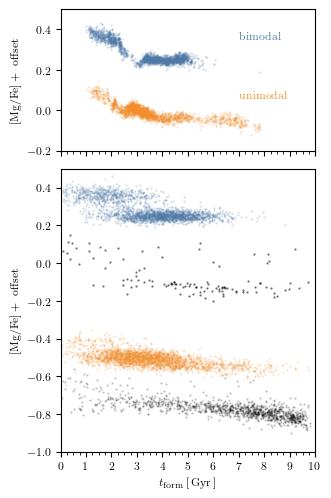

In [14]:
# same plot with errors

fig, axs = plt.subplots(2, 1, figsize=(columnwidth, 1.5*columnwidth), sharex=True, gridspec_kw={'height_ratios': [1, 2]})

logFeH0 = 0
dlogFeH = 0.05
s=0.4

# bimodal sim
offset = 0
data = extract_sim_data(gal0)
key = np.logical_and(data['logFeH'] > logFeH0 - dlogFeH/2, data['logFeH'] < logFeH0 + dlogFeH/2)
axs[0].scatter(data['tform'][key], data['logMgFe'][key]+offset, c=tb_c[0], s=s, alpha=0.2, label='bimodal')

data['tform'] = np.random.normal(data['tform'], 1)
data['logFeH'] = np.random.normal(data['logFeH'], 0.0075)
data['logMgFe'] = np.random.normal(data['logMgFe'], 0.012)
key = np.logical_and(data['logFeH'] > logFeH0 - dlogFeH/2, data['logFeH'] < logFeH0 + dlogFeH/2)
axs[1].scatter(data['tform'][key], data['logMgFe'][key]+offset, c=tb_c[0], s=s, alpha=0.2, label='bimodal')

# unimodal sim
offset = -0.3
data = extract_sim_data(gal1)
key = np.logical_and(data['logFeH'] > logFeH0 - dlogFeH/2, data['logFeH'] < logFeH0 + dlogFeH/2)
axs[0].scatter(data['tform'][key], data['logMgFe'][key]+offset, c=tb_c[1], s=s, alpha=0.2, label='bimodal')

offset = -0.8
data['tform'] = np.random.normal(data['tform'], 1.0)
data['logFeH'] = np.random.normal(data['logFeH'], 0.0075)
data['logMgFe'] = np.random.normal(data['logMgFe'], 0.012)
key = np.logical_and(data['logFeH'] > logFeH0 - dlogFeH/2, data['logFeH'] < logFeH0 + dlogFeH/2)
axs[1].scatter(data['tform'][key], data['logMgFe'][key]+offset, c=tb_c[1], s=s, alpha=0.2, label='unimodal')

# data
offset = -0.25
logFeH0 = -0.5
dlogFeH = 0.2
key = np.logical_and(MWdat['logFeH'] > logFeH0 - dlogFeH/2, MWdat['logFeH'] < logFeH0 + dlogFeH/2)
axs[1].scatter(10-MWdat['ages'][key], MWdat['logMgFe'][key]+offset, c='k', s=s, alpha=0.5, label='APOKASC3')

offset = -0.8
logFeH0 = 0.
dlogFeH = 0.2
key = np.logical_and(MWdat['logFeH'] > logFeH0 - dlogFeH/2, MWdat['logFeH'] < logFeH0 + dlogFeH/2)
axs[1].scatter(10-MWdat['ages'][key], MWdat['logMgFe'][key]+offset, c='k', s=s, alpha=0.2, label='APOKASC3')

# ax.set(xlim=(0, 8), ylim=(-0.1, 0.5), title=r'$-0.3 < [\textrm{Fe}/\textrm{H}] < -0.2$')
axs[0].set(xlim=(0, 10), ylim=(-0.2, 0.5))#, title=r'$[\textrm{Fe}/\textrm{H}] = 0$')
# axs[0].set(xlabel=r'$t_{\textrm{form}}\,[\,\textrm{Gyr}\,]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
axs[0].set(ylabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
axs[0].text(7, 0.35, r'$\textrm{bimodal}$', c=tb_c[0])
axs[0].text(7, 0.06, r'$\textrm{unimodal}$', c=tb_c[1])
axs[0].set(xticks=np.arange(0, 10+1, 1))
axs[0].set_xticks(np.arange(0, 10+0.25, 0.25), minor=True)

axs[1].set(xlabel=r'$t_{\textrm{form}}\,[\,\textrm{Gyr}\,]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
# axs[1].text(7, 0.35, r'$\textrm{bimodal}$', c=tb_c[0])
# axs[1].text(7, 0.06, r'$\textrm{unimodal}$', c=tb_c[1])
# axs[1].text(7, 0.08-0.27, r'$\textrm{APOKASC3}$', c='k')
axs[1].set(xticks=np.arange(0, 10+1, 1))
axs[1].set_xticks(np.arange(0, 10+0.25, 0.25), minor=True)
axs[1].set(ylim=(-1, 0.5))

# ax.legend(frameon=False)
fig.tight_layout()
# fig.savefig('alpha_vs_tform.pdf')

num logFeH0= -0.5  is  125
num logFeH0= 0.0  is  1175


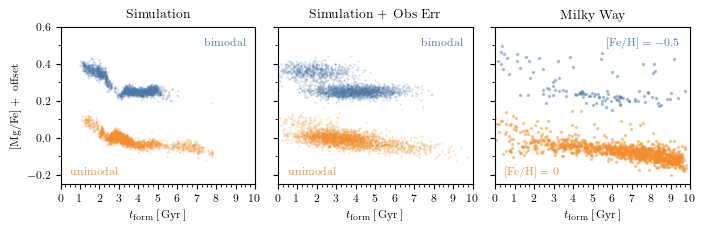

In [24]:
# same plot with errors
np.random.seed(42)

fig, axs = plt.subplots(1, 3, figsize=(textwidth, 0.7*columnwidth), sharex=True, sharey=True)

logFeH0 = 0
dlogFeH = 0.05
s=0.4

# bimodal sim
offset = 0
data = extract_sim_data(gal0)
key = np.logical_and(data['logFeH'] > logFeH0 - dlogFeH/2, data['logFeH'] < logFeH0 + dlogFeH/2)
axs[0].scatter(data['tform'][key], data['logMgFe'][key]+offset, c=tb_c[0], s=s, alpha=0.2, label='bimodal')

data['tform'] = np.random.normal(data['tform'], 1)
data['logFeH'] = np.random.normal(data['logFeH'], 0.0075)
data['logMgFe'] = np.random.normal(data['logMgFe'], 0.012)
key = np.logical_and(data['logFeH'] > logFeH0 - dlogFeH/2, data['logFeH'] < logFeH0 + dlogFeH/2)
axs[1].scatter(data['tform'][key], data['logMgFe'][key]+offset, c=tb_c[0], s=s, alpha=0.2, label='bimodal')

# unimodal sim
offset = -0.3
data = extract_sim_data(gal1)
key = np.logical_and(data['logFeH'] > logFeH0 - dlogFeH/2, data['logFeH'] < logFeH0 + dlogFeH/2)
axs[0].scatter(data['tform'][key], data['logMgFe'][key]+offset, c=tb_c[1], s=s, alpha=0.2, label='bimodal')

data['tform'] = np.random.normal(data['tform'], 1.0)
data['logFeH'] = np.random.normal(data['logFeH'], 0.0075)
data['logMgFe'] = np.random.normal(data['logMgFe'], 0.012)
key = np.logical_and(data['logFeH'] > logFeH0 - dlogFeH/2, data['logFeH'] < logFeH0 + dlogFeH/2)
axs[1].scatter(data['tform'][key], data['logMgFe'][key]+offset, c=tb_c[1], s=s, alpha=0.2, label='unimodal')

# data
s=2
alpha=0.4
offset = 0.1
logFeH0 = -0.5
dlogFeH = 0.2
key = np.logical_and(MWdat['logFeH'] > logFeH0 - dlogFeH/2, MWdat['logFeH'] < logFeH0 + dlogFeH/2)
key = np.logical_and(key, np.logical_not(np.isnan(MWdat['ages'])))
print('num logFeH0=', logFeH0, ' is ', np.sum(key))
axs[2].scatter(10-MWdat['ages'][key], MWdat['logMgFe'][key]+offset, c=tb_c[0], s=s, alpha=alpha, label='APOKASC3')

offset = -0.1
logFeH0 = 0.
dlogFeH = 0.2
key = np.logical_and(MWdat['logFeH'] > logFeH0 - dlogFeH/2, MWdat['logFeH'] < logFeH0 + dlogFeH/2)
key = np.logical_and(key, np.logical_not(np.isnan(MWdat['ages'])))
print('num logFeH0=', logFeH0, ' is ', np.sum(key))
axs[2].scatter(10-MWdat['ages'][key], MWdat['logMgFe'][key]+offset, c=tb_c[1], s=s, alpha=alpha, label='APOKASC3')

# ax.set(xlim=(0, 8), ylim=(-0.1, 0.5), title=r'$-0.3 < [\textrm{Fe}/\textrm{H}] < -0.2$')
axs[0].set(xlim=(0, 10), ylim=(-0.25, 0.6))#, title=r'$[\textrm{Fe}/\textrm{H}] = 0$')
# axs[0].set(xlabel=r'$t_{\textrm{form}}\,[\,\textrm{Gyr}\,]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
axs[0].set(ylabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
axs[0].text(9.5, 0.5, r'$\textrm{bimodal}$', c=tb_c[0], ha='right')
axs[0].text(0.5, -0.2, r'$\textrm{unimodal}$', c=tb_c[1])
axs[0].set(xticks=np.arange(0, 10+1, 1), yticks=np.arange(-0.2, 0.6+0.2, 0.2))
axs[0].set_yticks(np.arange(-0.2, 0.6+0.1, 0.1), minor=True)
axs[0].set_xticks(np.arange(0, 10+0.25, 0.25), minor=True)
axs[0].set(xlabel=r'$t_{\textrm{form}}\,[\,\textrm{Gyr}\,]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')


axs[1].set(xlabel=r'$t_{\textrm{form}}\,[\,\textrm{Gyr}\,]$')
axs[1].text(9.5, 0.5, r'$\textrm{bimodal}$', c=tb_c[0], ha='right')
axs[1].text(0.5, -0.2, r'$\textrm{unimodal}$', c=tb_c[1])

axs[2].set(xlabel=r'$t_{\textrm{form}}\,[\,\textrm{Gyr}\,]$')
axs[2].text(9.5, 0.5, r'$[\textrm{Fe}/\textrm{H}]=-0.5$', ha='right', c=tb_c[0])
axs[2].text(0.5, -0.2, r'$[\textrm{Fe}/\textrm{H}]=0$', c=tb_c[1])

axs[0].set_title(r'$\textrm{Simulation}$')
axs[1].set_title(r'$\textrm{Simulation + Obs Err}$')
axs[2].set_title(r'$\textrm{Milky Way}$')

# ax.legend(frameon=False)
fig.tight_layout()
fig.savefig('alpha_vs_tform_obserr.pdf')

In [21]:
np.sum(MWdat['age_err']/MWdat['ages'] < 0.125)

2142

(0.0, 10.0)

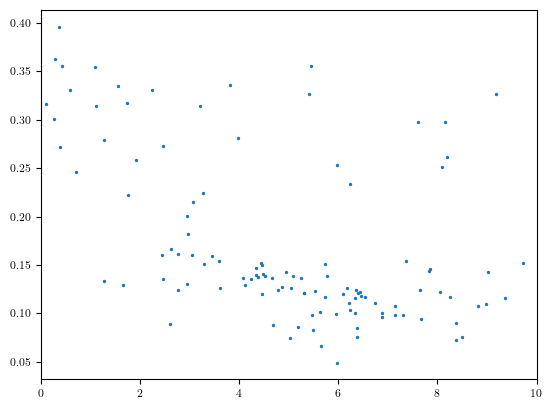

In [56]:
dlogFeH = 0.2
logFeH0 = -0.5
key = np.logical_and(MWdat['logFeH'] > logFeH0 - dlogFeH/2, MWdat['logFeH'] < logFeH0 + dlogFeH/2)
plt.scatter(10-MWdat['ages'][key], MWdat['logMgFe'][key], s=2)
# plt.scatter(MWdat['ages'][key], MWdat['logMgFe'][key], s=2)
plt.xlim(0, 10)

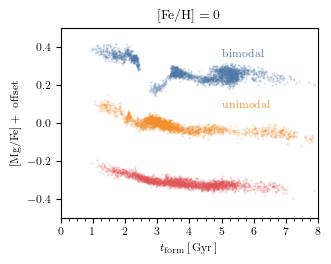

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.8*columnwidth))

logFeH0 = 0
dlogFeH = 0.05
s=0.4

data = simdata0
offset = 0
key = np.logical_and(data['logFeH'] > logFeH0 - dlogFeH/2, data['logFeH'] < logFeH0 + dlogFeH/2)
ax.scatter(data['tform'][key], data['logMgFe'][key]+offset, c=tb_c[0], s=s, alpha=0.2, label='bimodal')

data = simdata1
offset = -0.3
key = np.logical_and(data['logFeH'] > logFeH0 - dlogFeH/2, data['logFeH'] < logFeH0 + dlogFeH/2)
ax.scatter(data['tform'][key], data['logMgFe'][key]+offset, c=tb_c[1], s=s, alpha=0.2, label='unimodal')

data = simdata_iso
offset = -0.6
key = np.logical_and(data['logFeH'] > logFeH0 - dlogFeH/2, data['logFeH'] < logFeH0 + dlogFeH/2)
ax.scatter(data['tform'][key], data['logMgFe'][key]+offset, c=tb_c[2], s=s, alpha=0.2, label='isolated')

# ax.set(xlim=(0, 8), ylim=(-0.1, 0.5), title=r'$-0.3 < [\textrm{Fe}/\textrm{H}] < -0.2$')
ax.set(xlim=(0, 8), ylim=(-0.5, 0.5), title=r'$[\textrm{Fe}/\textrm{H}] = 0$')
ax.set(xlabel=r'$t_{\textrm{form}}\,[\,\textrm{Gyr}\,]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
ax.text(5, 0.35, r'$\textrm{bimodal}$', c=tb_c[0])
ax.text(5, 0.08, r'$\textrm{unimodal}$', c=tb_c[1])
ax.set(xticks=np.arange(0, 8+1, 1))
ax.set_xticks(np.arange(0, 8+0.25, 0.25), minor=True)

# ax.legend(frameon=False)
fig.tight_layout()
fig.savefig('alpha_vs_tform.pdf')

In [17]:
data

array({'logFeH': array([ 0.2551748 ,  0.19681853,  0.0879285 , ..., -0.02184737,
        0.0604107 , -0.02057733], dtype=float32), 'logMgFe': array([0.197018  , 0.21505532, 0.19271755, ..., 0.18167101, 0.17345908,
       0.17163192], dtype=float32), 'tform': array([ 7.1772461e+00,  6.0556641e+00,  4.6376953e+00, ...,
       -7.2265626e-04, -3.2861328e-03, -7.5585935e-03], dtype=float32)},
      dtype=object)